In [26]:
import os
import json
import argparse
import pprint
import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils import data
from bnaf import *
from tqdm import trange
from data.generate2d import sample2d, energy2d

# standard imports
import torch
import torch.nn as nn
from sklearn.datasets import make_moons
# from generate2d import sample2d, energy2d

# FrEIA imports
import FrEIA.framework as Ff
import FrEIA.modules as Fm

from nflows.distributions import normal


In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCHSIZE = 1000
N_DIM = 2

# we define a subnet for use inside an affine coupling block
# for more detailed information see the full tutorial
def subnet_fc(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, 512), nn.ReLU(),
                         nn.Linear(512,  dims_out))

# a simple chain of operations is collected by ReversibleSequential
inn = Ff.SequenceINN(N_DIM)
for k in range(8):
    inn.append(Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True)

inn.to(device)
optimizer = torch.optim.Adam(inn.parameters(), lr=0.001)

# a very basic training loop
for i in range(2000):
    optimizer.zero_grad()
    # sample data from the moons distribution
    data, label = make_moons(n_samples=BATCHSIZE, noise=0.05)
    x = torch.Tensor(data).to(device)
    # pass to INN and get transformed variable z and log Jacobian determinant
    z, log_jac_det = inn(x)
    
#     print(z.size())
#     plt.figure()
#     plt.plot(z.detach().numpy()[:,0], z.detach().numpy()[:,1],'r.')
#     plt.plot(x.detach().numpy()[:,0], x.detach().numpy()[:,1],'b.')
    
    # calculate the negative log-likelihood of the model with a standard normal prior
#     loss = 0.5*torch.sum(z**2, 1) - log_jac_det
    
#     tt1 = 0.5*torch.sum(z**2, 1)
#     tt2 = torch.distributions.Normal(torch.zeros_like(z), torch.ones_like(z)).log_prob(z).sum(-1)
    shape = z.shape[1:]
    log_z = normal.StandardNormal(shape=shape).log_prob(z)
    
#     print(tt1.mean())
#     print(tt2.mean())
#     print(tt3.mean())
    
    loss = log_z + log_jac_det
    loss = -loss.mean() / N_DIM
    # backpropagate and update the weights
    loss.backward()
    optimizer.step()
    
    if i % 100==0:
        print(i,loss)


0 tensor(1.2285, grad_fn=<DivBackward0>)
100 tensor(0.5087, grad_fn=<DivBackward0>)
200 tensor(0.3807, grad_fn=<DivBackward0>)
300 tensor(0.3197, grad_fn=<DivBackward0>)
400 tensor(0.3039, grad_fn=<DivBackward0>)
500 tensor(0.2546, grad_fn=<DivBackward0>)
600 tensor(0.2427, grad_fn=<DivBackward0>)
700 tensor(0.2101, grad_fn=<DivBackward0>)
800 tensor(0.2032, grad_fn=<DivBackward0>)
900 tensor(0.2167, grad_fn=<DivBackward0>)
1000 tensor(0.1886, grad_fn=<DivBackward0>)
1100 tensor(0.1981, grad_fn=<DivBackward0>)
1200 tensor(0.1922, grad_fn=<DivBackward0>)
1300 tensor(0.1677, grad_fn=<DivBackward0>)
1400 tensor(0.1885, grad_fn=<DivBackward0>)
1500 tensor(0.1863, grad_fn=<DivBackward0>)
1600 tensor(0.1855, grad_fn=<DivBackward0>)
1700 tensor(0.1883, grad_fn=<DivBackward0>)
1800 tensor(0.1880, grad_fn=<DivBackward0>)
1900 tensor(0.1697, grad_fn=<DivBackward0>)


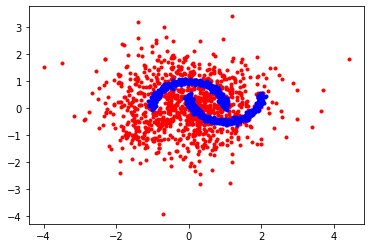

In [28]:
plt.figure()
plt.plot(z.detach().numpy()[:,0], z.detach().numpy()[:,1],'r.')
plt.plot(x.detach().numpy()[:,0], x.detach().numpy()[:,1],'b.')

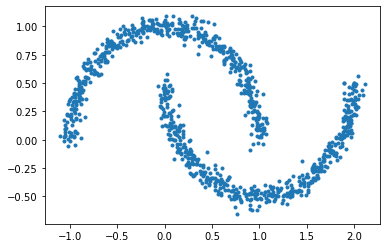

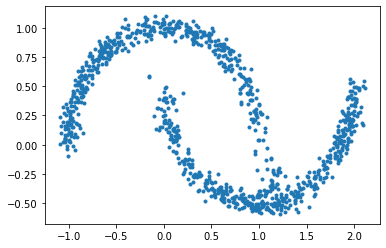

In [29]:
data, label = make_moons(n_samples=1000, noise=0.05)
plt.figure()
plt.plot(data[:,0], data[:,1],'.')


# sample from the INN by sampling from a standard normal and transforming
# it in the reverse direction
nsam = 1000
zzz = torch.randn(nsam, N_DIM)
samples0, _ = inn(zzz, rev=True)

samples = samples0.detach().numpy()
plt.figure()
plt.plot(samples[:,0], samples[:,1],'.')

In [31]:
np.log(3)

1.0986122886681098

In [33]:
np.log(5)

1.6094379124341003